In [1]:
import os

import mlflow
import joblib
import datetime

import numpy as np
import pandas as pd

import dask.dataframe as dd
from joblib import parallel_backend
from dask.diagnostics import ProgressBar

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from src import utils

sns.set()

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/heapdict.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class heapdict(collections.MutableMapping):


In [2]:
# client = Client()
pbar = ProgressBar()
pbar.register()

In [3]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, "D")
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, "D")

## Data Ingestion

In [4]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [5]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
# TODO: move to reading from Ceph after slow read blocker is removed
DATA_ROOT_DIR = "/home/kachauha/Downloads/"
df4 = dd.read_parquet(
    os.path.join(DATA_ROOT_DIR, "data_Q4_2018_parquet"), engine="pyarrow", index=False
)
df3 = dd.read_parquet(
    os.path.join(DATA_ROOT_DIR, "data_Q3_2018_parquet"), engine="pyarrow", index=False
)
df = dd.concat(dfs=[df3, df4], interleave_partitions=True)
# df = dd.read_csv(
#     "s3://DH-PLAYPEN/kachauha/*/*.csv",
#     storage_options={
#         "client_kwargs": {"endpoint_url": "https://s3.upshift.redhat.com/"}
#     },
#     dtype=custom_dtypes
# )
df = utils.optimal_repartition_df(df[df["model"].str.startswith("HGST")])

[########################################] | 100% Completed | 35.8s


In [6]:
MANUFACTURER = "hgst"

In [7]:
# convert from str to datetime
df["date"] = df["date"].astype("datetime64")

In [8]:
failed_sers = df[df["failure"] == 1]["serial_number"].compute()
failed_sers.head()

[########################################] | 100% Completed | 31.6s


499      PL2331LAHA37GJ
3694     PL2331LAGRWU3J
27975    PL1331LAGRH32H
52365    PL1331LAHBZ49H
93179    PL1331LAHD4DYH
Name: serial_number, dtype: object

## Feature Selection

In [9]:
# start off with critical columns as indicated from 3 sources
CRITICAL_STATS = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 190, 192, 193, 194, 196, 197, 198]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ["smart_{}_raw".format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ["smart_{}_normalized".format(i) for i in CRITICAL_STATS]

In [10]:
print("hgst")
nan_ct = utils.get_nan_count_percent(df).compute()
# nan_ct = utils.get_nan_count_percent(df[crit_cols_raw + crit_cols_normalized])
nan_ct.sort_values(by="percent")

hgst
[########################################] | 100% Completed | 31.3s
[########################################] | 100% Completed | 31.9s


,count,percent
date,0,0.00000
serial_number,0,0.00000
model,0,0.00000
capacity_bytes,0,0.00000
failure,0,0.00000
smart_12_raw,75,0.00002
smart_192_normalized,75,0.00002
smart_192_raw,75,0.00002
smart_193_normalized,75,0.00002
smart_193_raw,75,0.00002


In [11]:
corr_cols = ["failure", "capacity_bytes"] + [
    col for col in nan_ct[(nan_ct["percent"] < 0.25)].index if col.startswith("smart")
]
# crit_cols_raw + crit_cols_normalized
corr = df[corr_cols].corr().compute()
corr["failure"].abs().sort_values(ascending=False)

[########################################] | 100% Completed |  1min 43.0s


failure                 1.000000
smart_197_raw           0.045708
smart_196_raw           0.019794
smart_5_normalized      0.015360
smart_5_raw             0.014757
smart_196_normalized    0.012432
smart_1_normalized      0.006271
smart_198_raw           0.004163
smart_2_raw             0.002221
smart_2_normalized      0.001268
smart_8_normalized      0.000617
smart_194_normalized    0.000487
smart_3_normalized      0.000475
smart_1_raw             0.000455
smart_12_raw            0.000412
smart_194_raw           0.000367
smart_192_normalized    0.000364
smart_192_raw           0.000360
smart_193_normalized    0.000353
smart_193_raw           0.000340
smart_4_raw             0.000288
smart_10_normalized     0.000217
smart_3_raw             0.000205
smart_8_raw             0.000172
smart_9_raw             0.000153
capacity_bytes          0.000130
smart_199_raw           0.000081
smart_10_raw            0.000080
smart_9_normalized      0.000056
smart_7_normalized      0.000016
smart_7_ra

In [12]:
# re-selection of critical columns based on number of nans and correlations
# CRITICAL_STATS = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 192, 193, 194, 196, 197, 198]
CRITICAL_STATS = [1, 2, 3, 5, 8, 9, 194, 196, 197, 198]
crit_cols_raw = ["smart_{}_raw".format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ["smart_{}_normalized".format(i) for i in CRITICAL_STATS]

In [13]:
corr_cols = ["failure", "capacity_bytes"] + crit_cols_raw + crit_cols_normalized
corr = df[corr_cols].corr().compute()
corr["failure"].abs().sort_values(ascending=False)

[########################################] | 100% Completed | 45.4s


failure                 1.000000
smart_197_raw           0.045708
smart_196_raw           0.019794
smart_5_normalized      0.015360
smart_5_raw             0.014757
smart_196_normalized    0.012432
smart_1_normalized      0.006271
smart_198_raw           0.004163
smart_2_raw             0.002221
smart_2_normalized      0.001268
smart_8_normalized      0.000617
smart_194_normalized    0.000487
smart_3_normalized      0.000475
smart_1_raw             0.000455
smart_194_raw           0.000367
smart_3_raw             0.000205
smart_8_raw             0.000172
smart_9_raw             0.000153
capacity_bytes          0.000130
smart_9_normalized      0.000056
smart_197_normalized         NaN
smart_198_normalized         NaN
Name: failure, dtype: float64

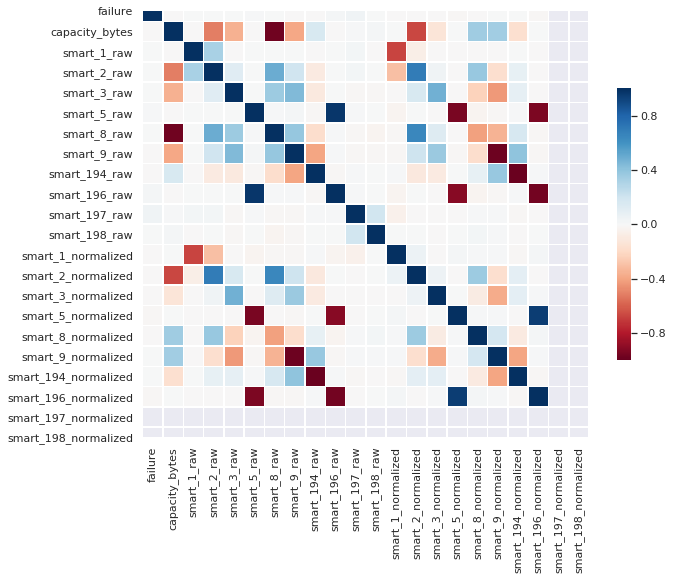

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr,
    ax=ax,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cmap="RdBu",
    cbar_kws={"shrink": 0.5},
)

In [15]:
# for now, keep the highly correlated ones along with smart 9. maybe there is non linear correlation
df = df[
    ["date", "serial_number", "model", "capacity_bytes", "failure"]
    + crit_cols_raw
    + crit_cols_normalized
]

## Handle Missing Values

In [16]:
# what is the nan situation like
utils.get_nan_count_percent(df).compute()

[########################################] | 100% Completed | 30.4s
[########################################] | 100% Completed | 28.7s


,count,percent
date,0,0.00000
serial_number,0,0.00000
model,0,0.00000
capacity_bytes,0,0.00000
failure,0,0.00000
smart_1_raw,75,0.00002
smart_2_raw,75,0.00002
smart_3_raw,75,0.00002
smart_5_raw,75,0.00002
smart_8_raw,75,0.00002


In [17]:
# failed drives that have nan values
failed_df = df[df["serial_number"].isin(failed_sers)]
utils.get_nan_count_percent(failed_df).compute()

[########################################] | 100% Completed | 28.7s
[########################################] | 100% Completed | 29.8s


,count,percent
date,0,0.0
serial_number,0,0.0
model,0,0.0
capacity_bytes,0,0.0
failure,0,0.0
smart_1_raw,0,0.0
smart_2_raw,0,0.0
smart_3_raw,0,0.0
smart_5_raw,0,0.0
smart_8_raw,0,0.0


In [18]:
# drop the nans that occur in working hard drives, keep the ones in failing ones for now
df = df[(df["serial_number"].isin(failed_sers)) | ((~df["smart_1_raw"].isna()))]

# shouldnt have any nan values from working drives now
utils.get_nan_count_percent(df).compute()

[########################################] | 100% Completed | 30.3s
[########################################] | 100% Completed | 32.3s


,count,percent
date,0,0.0
serial_number,0,0.0
model,0,0.0
capacity_bytes,0,0.0
failure,0,0.0
smart_1_raw,0,0.0
smart_2_raw,0,0.0
smart_3_raw,0,0.0
smart_5_raw,0,0.0
smart_8_raw,0,0.0


## Prepare + Preprocess

### Add RUL, Class labels

In [19]:
# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta["date"].max() - rul_meta["date"])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
df = (
    df.groupby("serial_number")
    .apply(utils.append_rul_days_column, meta=rul_meta)
    .reset_index(drop=True)
)

In [20]:
# remove working drive data that is recorded after [quarter end minus 6 weeks]
# because we dont know (as of quarter end) if those drives survived more than 6 weeks or not
df = df[
    (df["serial_number"].isin(failed_sers))
    | (df["rul_days"] >= WARNING_THRESHOLD_NDAYS)
]
print(dd.compute(df.shape))

[########################################] | 100% Completed |  1min 16.1s
((2902270, 26),)


In [21]:
# NOTE: assignment must be done in th
# df.head()is order otherwise it wont be correct. FIXME
# assign all as good initially
df["status"] = 0

# overwrite those which have rul less than 6 weeks as warning
df["status"] = df["status"].mask(df["rul_days"] < WARNING_THRESHOLD_NDAYS, 1)

# overwrite those which have rul less than 2 weeks as bad
df["status"] = df["status"].mask(df["rul_days"] < BAD_THRESHOLD_NDAYS, 2)

In [14]:
df = utils.optimal_repartition_df(df)

[########################################] | 100% Completed |  4min 10.0s


### Downsample

In [22]:
num_working_serials = 5000
working_sers = df[~df["serial_number"].isin(failed_sers)]["serial_number"].unique()
working_repr_sers = working_sers.sample(
    frac=(num_working_serials / len(working_sers))
).compute()

[########################################] | 100% Completed |  1min 17.1s
[########################################] | 100% Completed |  1min 10.5s


In [23]:
# preprocess only downsampled data
df = df[
    (df["serial_number"].isin(failed_sers))
    | df["serial_number"].isin(working_repr_sers.sample(num_working_serials))
]

In [25]:
df = df.compute()

[########################################] | 100% Completed |  1min 14.8s


### Stratified, Drive-wise Train/Test Split
To ensure there is no data leakage, i.e. overalap in the samples used in training and those used in testing, split data according to serial numbers. This way, all the data from a hard drive will be entirely in the test set or entirely in the training set.

In [26]:
# ['date', 'serial_number', 'model', 'failure', 'rul_days', 'status']
# ['serial_number', 'status']
X_arr = df.drop(
    ["date", "serial_number", "model", "failure", "rul_days", "status"], axis=1
)
Y_arr = df[["serial_number", "status"]]

**TODO** Currently, working representative drives are chosen randomly. Update this to be more intelligent

In [28]:
# failed serials left after reduction
failed_sers_red = pd.Series(Y_arr["serial_number"].unique())
failed_sers_red = failed_sers_red[failed_sers_red.isin(failed_sers)]

In [29]:
# working serials left after reduction
working_sers_red = pd.Series(Y_arr["serial_number"].unique())
working_sers_red = working_sers_red[~working_sers_red.isin(failed_sers)]

In [30]:
# split working and failed
working_train, working_test = train_test_split(
    working_sers_red, test_size=0.2, random_state=42
)
failed_train, failed_test = train_test_split(
    failed_sers_red, test_size=0.2, random_state=42
)

In [31]:
# use serial numbers to generate train/test set
# CHECKED OK - train/test ratio 0.8, fail/work and overall both
X_train_work = X_arr[Y_arr["serial_number"].isin(working_train)]
X_train_fail = X_arr[Y_arr["serial_number"].isin(failed_train)]
X_train = pd.concat([X_train_work, X_train_fail])

Y_train_work = Y_arr[Y_arr["serial_number"].isin(working_train)]["status"]
Y_train_fail = Y_arr[Y_arr["serial_number"].isin(failed_train)]["status"]
Y_train = pd.concat([Y_train_work, Y_train_fail])

X_test_work = X_arr[Y_arr["serial_number"].isin(working_test)]
X_test_fail = X_arr[Y_arr["serial_number"].isin(failed_test)]
X_test = pd.concat([X_test_work, X_test_fail])

Y_test_work = Y_arr[Y_arr["serial_number"].isin(working_test)]["status"]
Y_test_fail = Y_arr[Y_arr["serial_number"].isin(failed_test)]["status"]
Y_test = pd.concat([Y_test_work, Y_test_fail])

In [32]:
print(X_train_fail.shape)
print(X_test_fail.shape)
print(X_train_work.shape)
print(X_test_work.shape)

(2953, 21)
(631, 21)
(521571, 21)
(130981, 21)


### Scale

In [34]:
# robust scaling because of outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Train

In [36]:
# classification categories
CLASSES = ["good", "warning", "bad"]

### Vanilla Decision Tree

In [38]:
# with joblib.parallel_backend('dask'):
dt_clf = DecisionTreeClassifier(class_weight="balanced")
dt_clf.fit(X_train_scaled, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
# EXPANDING
# with joblib.parallel_backend('dask'):
# get preds
dt_preds = dt_clf.predict(scaler.transform(X_test))
dt_confmat = confusion_matrix(Y_test, dt_preds)

print(np.around(dt_confmat, decimals=2))
print(classification_report(Y_test, dt_preds, target_names=["good", "warning", "bad"]))

[[130991    143    199]
 [   130     19     27]
 [    69     14     20]]
              precision    recall  f1-score   support

        good       1.00      1.00      1.00    131333
     warning       0.11      0.11      0.11       176
         bad       0.08      0.19      0.11       103

    accuracy                           1.00    131612
   macro avg       0.40      0.43      0.41    131612
weighted avg       1.00      1.00      1.00    131612



In [44]:
fname = "../../../models/{}_dt_predictor_{}.joblib".format(
    MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
)
joblib.dump(dt_clf, fname)

['../models/hgst_dt_predictor_Aug_26_2019_15_20_18.joblib']

In [43]:
fname = "../../../models/{}_dt_preprocessor_{}.joblib".format(
    MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
)
joblib.dump(scaler, fname)

['../models/hgst_dt_preprocessor_Aug_26_2019_15_20_02.joblib']

### Vanilla Random Forest

In [41]:
rf_clf = RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)
rf_clf.fit(X_train_scaled, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [42]:
# get preds
rf_preds = rf_clf.predict(scaler.transform(X_test))
rf_confmat = confusion_matrix(Y_test, rf_preds)

print(np.around(rf_confmat, decimals=2))
print(classification_report(Y_test, rf_preds, target_names=["good", "warning", "bad"]))
print(
    "========================================================================================"
)

[[131250     56     27]
 [   176      0      0]
 [   103      0      0]]
              precision    recall  f1-score   support

        good       1.00      1.00      1.00    131333
     warning       0.00      0.00      0.00       176
         bad       0.00      0.00      0.00       103

    accuracy                           1.00    131612
   macro avg       0.33      0.33      0.33    131612
weighted avg       1.00      1.00      1.00    131612



### SVM

In [ ]:
svm_clf = SVC(
    class_weight="balanced", probability=True, cache_size=512, random_state=24
)
svm_clf.fit(X_train_scaled, Y_train)

In [ ]:
svm_preds = svm_clf.predict(scaler.transform(X_test))
svm_confmat = confusion_matrix(Y_test, svm_preds)

print(np.around(svm_confmat / svm_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, svm_preds))

## Gradient Boosting Classifier

In [ ]:
with parallel_backend("dask"):
    gb_clf = GradientBoostingClassifier()
    gb_clf.fit(X_train_scaled, Y_train)

In [ ]:
gb_preds = gb_clf.predict(scaler.transform(X_test))
gb_confmat = confusion_matrix(Y_test, gb_preds)

print(np.around(gb_confmat / gb_confmat.sum(axis=1, keepdims=True), decimals=2))
print(classification_report(Y_test, gb_preds, target_names=["good", "warning", "bad"]))

## MLflow logging
TODO: cleanup

In [43]:
mlflow.set_experiment("vanilla_iid")

In [59]:
with mlflow.start_run():
    # data params
    nwork, nfail = np.bincount(np.isin(Y_arr["serial_number"].unique(), failed_sers))
    mlflow.log_param("nwork", nwork)
    mlflow.log_param("nfail", nfail)

    # training params
    mlflow.log_param("scaler", "robust")
    mlflow.log_param("model", "dt")
    mlflow.log_param("n_feat", dt_clf.n_features_)

    # results
    precs, recs, f1s, _ = precision_recall_fscore_support(Y_test, dt_preds)
    for cl, p in zip(CLASSES, precs):
        mlflow.log_metric("precision_{}".format(cl), p)
    for cl, r in zip(CLASSES, recs):
        mlflow.log_metric("recall_{}".format(cl), r)
    for cl, f1 in zip(CLASSES, f1s):
        mlflow.log_metric("f1_{}".format(cl), f1)

    fname = "{}_dt_confmat_{}.npy".format(
        MANUFACTURER, datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
    )
    np.save(fname, dt_confmat)
    mlflow.log_artifact(fname)